In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

### Preparing The Data

In [2]:
import os
os.getcwd()

'C:\\Users\\Krishna'

In [3]:
import pathlib as pl
data_dir = pl.Path('C:\\Users\\Krishna\\Downloads\\MLA_Project\\Transfer_learning\\Scalogram_photos')
data_dir

WindowsPath('C:/Users/Krishna/Downloads/MLA_Project/Transfer_learning/Scalogram_photos')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

8800


C:\Users\Krishna\Downloads\MLA_Project\Transfer_learning\Scalogram_photos\Low_img\img_1.jpg


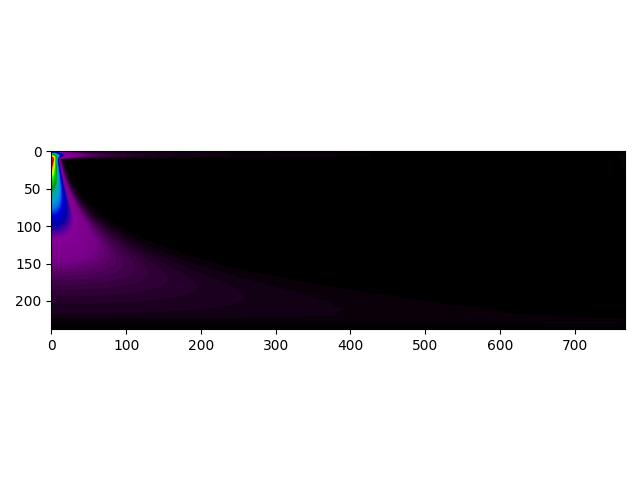

In [5]:
# Scalograms corresponding to Low mental workload
low_mwl = list(data_dir.glob('Low_img/*'))
print(low_mwl[0])
PIL.Image.open(str(low_mwl[0]))

C:\Users\Krishna\Downloads\MLA_Project\Transfer_learning\Scalogram_photos\High_img\img_4401.jpg


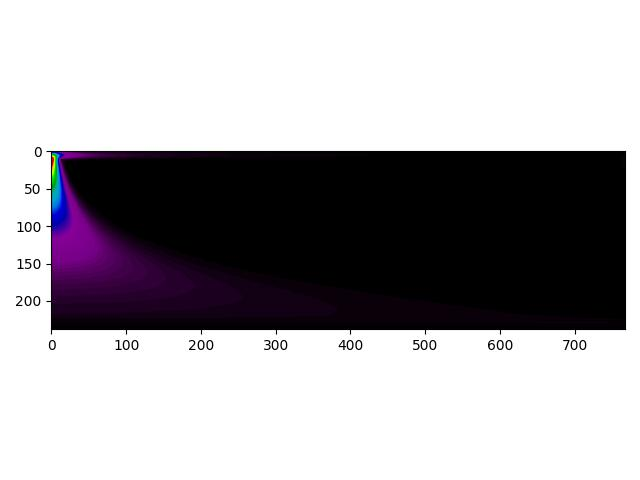

In [6]:
# Scalograms corresponding to Low mental workload
high_mwl = list(data_dir.glob('High_img/*'))
print(high_mwl[0])
PIL.Image.open(str(high_mwl[0]))

In [7]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8800 files belonging to 2 classes.
Using 7040 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8800 files belonging to 2 classes.
Using 1760 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['High_img', 'Low_img']


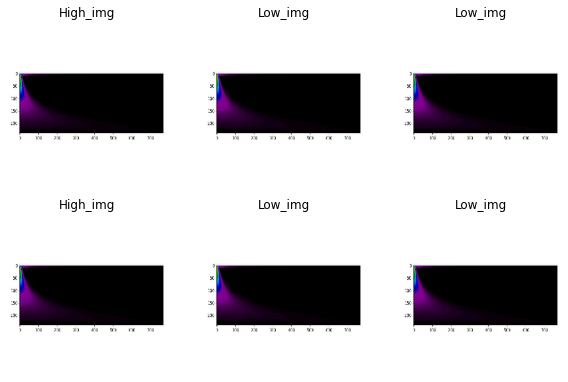

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Retraining the pre-trained model

In [11]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='softmax'))

In [12]:
# Glance of built model
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrapp  (None, 2048)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 1)                513       
 pper)                                                           
                                                                 
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
____________________________________

In [13]:
resnet_model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=[tf.keras.metrics.Accuracy()])

In [14]:
epochs=5
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
220/220 [==============================] - 313s 1s/step - loss: 0.7262 - accuracy: 0.5030 - val_loss: 0.6601 - val_accuracy: 0.4881
Epoch 2/5
220/220 [==============================] - 306s 1s/step - loss: 0.6644 - accuracy: 0.5030 - val_loss: 0.6296 - val_accuracy: 0.4881
Epoch 3/5
220/220 [==============================] - 325s 1s/step - loss: 0.6441 - accuracy: 0.5030 - val_loss: 0.6059 - val_accuracy: 0.4881
Epoch 4/5
220/220 [==============================] - 1577s 7s/step - loss: 0.6151 - accuracy: 0.5030 - val_loss: 0.5761 - val_accuracy: 0.4881
Epoch 5/5
220/220 [==============================] - 391s 2s/step - loss: 0.5874 - accuracy: 0.5030 - val_loss: 0.5623 - val_accuracy: 0.4881


## Evaluating The Model

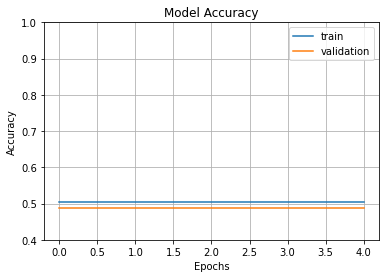

In [15]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

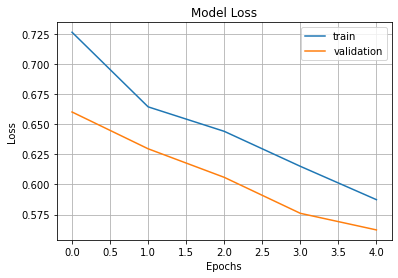

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

In [17]:
import cv2
image=cv2.imread(str(low_mwl[78]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)


(1, 180, 180, 3)


In [18]:
pred=resnet_model.predict(image)
print(pred)

1/1 [==============================] - 2s 2s/step
[[1.]]


In [19]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is High_img
